# SVR Analysis

## Description

This notebook analyses SVR-predicted trajectories. 

## Author

- Sophia Chiang
- June 14th 2024

In [106]:
# Ensure latest module is used
from importlib import reload
import project_functions
reload(project_functions)

# Import relevant libraries
import pandas as pd
import os
from project_functions import get_lap, plot_traj_reward, plot_misalignment, interpolate_trajectories, print_huber_losses

# PD Control Training Data

In [107]:
foldername = "test_data"

# Get PD data
filepath_pd = os.path.join(foldername, 'test_pd_data.csv')
df_pd = pd.read_csv(filepath_pd)

x_pd = df_pd['cur_pos_x'].values
y_pd = df_pd['cur_pos_z'].values
ytrue = df_pd['steering_angle']

# Get one lap of trajectory
x_pd_lap, y_pd_lap = get_lap(x_pd, y_pd, 0.03, 0.03)

# Get ground truth data
filepath_gt = os.path.join(foldername, 'gt_udem1.csv')
df_gt = pd.read_csv(filepath_gt)

x_gt = df_gt['bez_x'].values
y_gt = df_gt['bez_z'].values

# Get one lap of trajectory
x_gt_lap, y_gt_lap = get_lap(x_gt, y_gt, 0.03, 0.03)

## Raw Data - Unweighted

Model Test Huber Loss: 0.10230555438079605
PD and Model Huber Loss: 0.00042490619024889624
Ground Truth and Model Huber Loss: 0.0009668340130562791


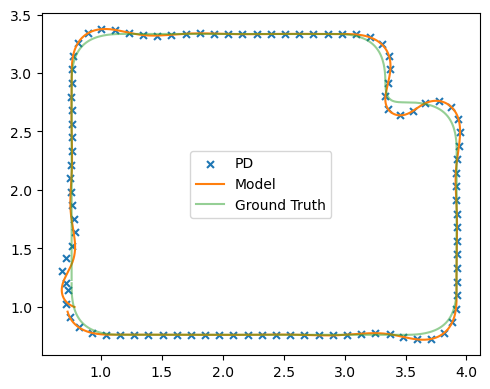

In [108]:
model_name = "unweighted_svr_model_raw_pd"

# Get unweighted model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', ''))) # Ensure data entries are floats not strings
ypred = df_model['steering_angle'].values

x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.7, 0.04)

# Evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# Ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)

plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Unweighted SVR Model Trained on Raw PD Data")
#plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)

## Raw Data - Weighted

Model Test Huber Loss: 0.04494061799599221
PD and Model Huber Loss: 0.0007651636259514826
Ground Truth and Model Huber Loss: 0.0006360166176088455


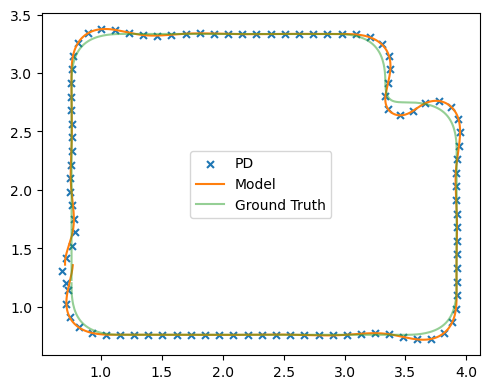

In [113]:
model_name = "weighted_svr_model_raw_pd"

# Get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.7, 0.005)

# Evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# Ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)
plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Weighted SVR Model Trained on Raw PD Data")
#plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)


## Processed Data - Unweighted

Model Test Huber Loss: 0.1055967342896053
PD and Model Huber Loss: 0.9291563789560967
Ground Truth and Model Huber Loss: 0.9323434655768373


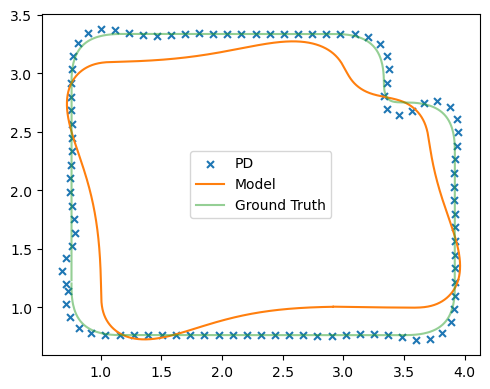

In [114]:
model_name = "unweighted_svr_model_processed_pd"

# Get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.005, 0.005)

# Evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# Ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)
plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Unweighted SVR Model Trained on Processed PD Data")
#plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)

## Processed Data - Unweighted Polynomial Features

Model Test Huber Loss: 0.057754147164699586
PD and Model Huber Loss: 0.0004227237628798572
Ground Truth and Model Huber Loss: 0.00037439693756831697


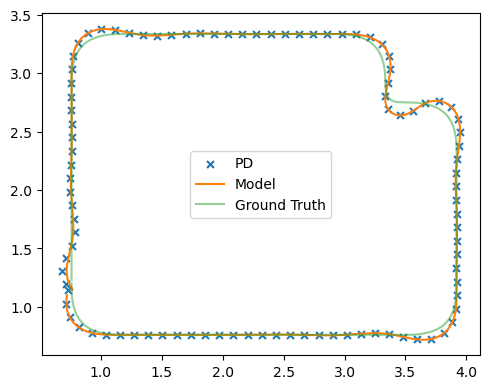

In [115]:
model_name = "unweighted_svr_poly_processed_pd"

# Get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.05, 0.05)

# Evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# Ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)
plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Weighted SVR Model Trained on Processed \nPD Data with Polynomial Features")
#plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)

## Processed Data - Weighted Polynomial Features

Model Test Huber Loss: 0.1305490351634239
PD and Model Huber Loss: 0.0011770932509248815
Ground Truth and Model Huber Loss: 0.0011024350632356697


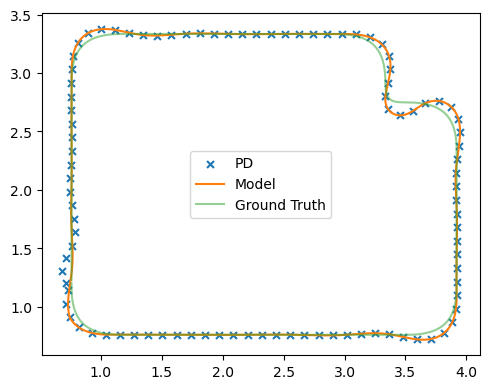

In [116]:
model_name = "weighted_svr_poly_processed_pd"

# Get base model with raw data test results
filepath = os.path.join(foldername, f'test_{model_name}_data.csv')
df_model = pd.read_csv(filepath)

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

x_model = df_model['cur_pos_x'].values
y_model = df_model['cur_pos_z'].values

df_model['steering_angle'] = df_model['steering_angle'].apply(lambda x: float(x.replace('[', '').replace(']', '')))
ypred = df_model['steering_angle'].values
x_model_lap, y_model_lap = get_lap(x_model, y_model, 0.05, 0.005)

# Evaluate model on test data
x_gt_interp, y_gt_interp, x_pd_interp, y_pd_interp = interpolate_trajectories(x_gt_lap, y_gt_lap, x_pd_lap, y_pd_lap, x_model_lap, y_model_lap)

# Ensure ypred and ytrue lengths match
ytrue = ytrue[:len(ypred)]
ypred = ypred[:len(ytrue)]

print_huber_losses(ytrue, ypred, x_pd_interp, y_pd_interp, x_gt_interp, y_gt_interp, x_model_lap, y_model_lap)
plot_traj_reward(x_pd_lap, y_pd_lap, x_model_lap, y_model_lap, x_gt_lap, y_gt_lap, df_model, df_pd, "Weighted SVR Model Trained on Processed \nPD Data with Polynomial Features")
#plot_misalignment(x_model_lap, y_model_lap, x_gt_lap, y_gt_lap)